In [345]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

##from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


import os
for dirname, _, filenames in os.walk('/archive'):
    for i, filename in enumerate(filenames):
        if i<5:
            print(os.path.join(dirname,filename))

In [346]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("/Users/benmiller/downloads/cs_349/spring2021-hw6-deep-learning-bmm1249/archive/Data/Stocks/{}.us.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

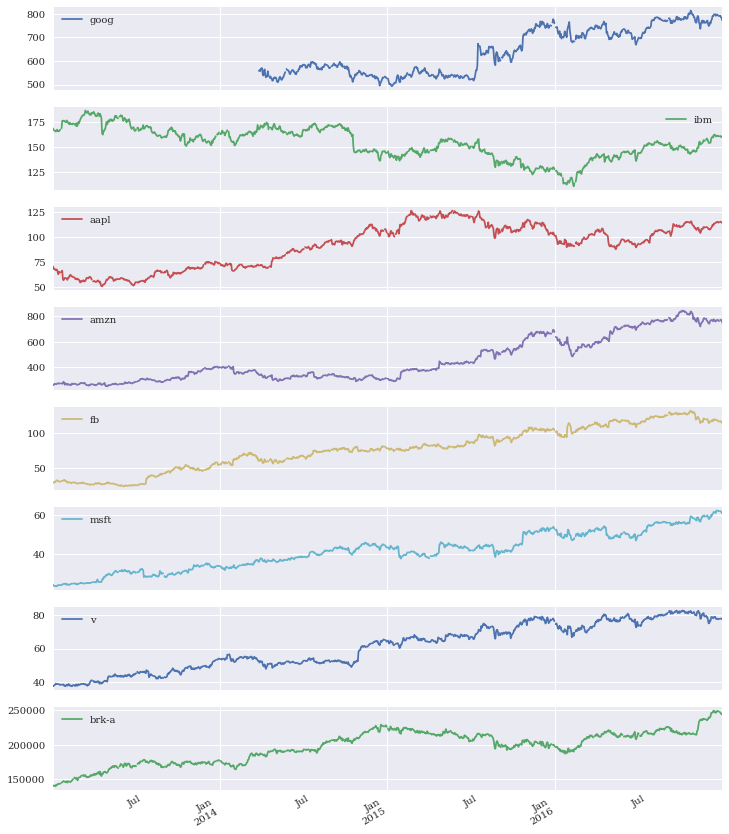

In [347]:
dates = pd.date_range('2013-01-02','2016-12-31',freq='B')
symbols = ['goog','ibm','aapl','amzn','fb','msft','v','brk-a']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
df.plot(figsize=(12, 16), subplots=True);

In [348]:
df.head(n = 10)

,goog,ibm,aapl,amzn,fb,msft,v,brk-a
2013-01-02,NaN,168.86,70.935,257.31,28.00,24.306,37.427,139610.00
2013-01-03,NaN,167.96,70.039,258.48,27.77,23.980,37.453,140549.00
2013-01-04,NaN,166.83,68.088,259.15,28.76,23.531,37.760,140803.06
2013-01-07,NaN,166.11,67.689,268.46,29.42,23.489,38.029,140190.00
2013-01-08,NaN,165.88,67.871,266.38,29.06,23.364,38.384,141000.00
2013-01-09,NaN,165.40,66.808,266.35,30.59,23.497,38.968,140000.00
2013-01-10,NaN,165.89,67.636,265.34,31.30,23.284,38.661,141768.00
2013-01-11,NaN,167.24,67.222,267.94,31.72,23.610,38.816,141525.00
2013-01-14,NaN,165.63,64.827,272.73,30.95,23.663,38.693,143000.00
2013-01-15,NaN,165.55,62.781,271.90,30.10,23.942,38.645,143205.00


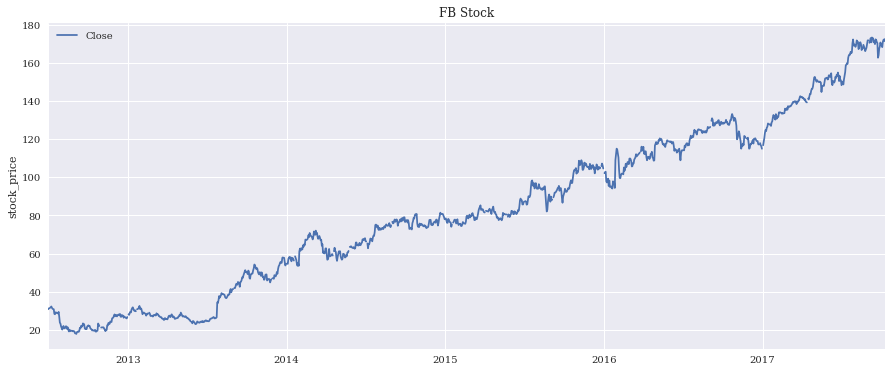

In [349]:
dates = pd.date_range('2012-07-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_ibm=pd.read_csv("/Users/benmiller/downloads/cs_349/spring2021-hw6-deep-learning-bmm1249/archive/Data/Stocks/fb.us.txt", parse_dates=True, index_col=0)
df_ibm=df1.join(df_ibm)
df_ibm[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("FB Stock")
plt.show()

In [350]:
df_ibm=df_ibm[['Close']]
df_ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1378 entries, 2012-07-02 to 2017-10-11
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1329 non-null   float64
dtypes: float64(1)
memory usage: 61.5 KB


In [351]:
df_ibm=df_ibm.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))
#df_ibm

In [352]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    indices = np.random.choice(data.shape[0], data.shape[0], replace = False)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = [30, 60, 120, 240] # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back[0])
x_train2, y_train2, x_test2, y_test2 = load_data(df_ibm, look_back[1])
x_train3, y_train3, x_test3, y_test3 = load_data(df_ibm, look_back[2])
x_train4, y_train4, x_test4, y_test4 = load_data(df_ibm, look_back[3])

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1078, 29, 1)
y_train.shape =  (1078, 1)
x_test.shape =  (270, 29, 1)
y_test.shape =  (270, 1)


In [353]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
x_train2 = torch.from_numpy(x_train2).type(torch.Tensor)
x_test2 = torch.from_numpy(x_test2).type(torch.Tensor)
y_train2 = torch.from_numpy(y_train2).type(torch.Tensor)
y_test2 = torch.from_numpy(y_test2).type(torch.Tensor)
x_train3 = torch.from_numpy(x_train3).type(torch.Tensor)
x_test3 = torch.from_numpy(x_test3).type(torch.Tensor)
y_train3 = torch.from_numpy(y_train3).type(torch.Tensor)
y_test3 = torch.from_numpy(y_test3).type(torch.Tensor)
x_train4 = torch.from_numpy(x_train4).type(torch.Tensor)
x_test4 = torch.from_numpy(x_test4).type(torch.Tensor)
y_train4 = torch.from_numpy(y_train4).type(torch.Tensor)
y_test4 = torch.from_numpy(y_test4).type(torch.Tensor)
#y_test2 = torch.clone(y_test)
#y_test3 = torch.clone(y_test)
#y_test4 = torch.clone(y_test)

In [354]:
y_train.size(),x_train.size()

(torch.Size([1078, 1]), torch.Size([1078, 29, 1]))

In [355]:
# Build model
#####################
input_dim = [1, 1, 1, 1]
hidden_dim = [32, 32, 32, 32]
num_layers = [2, 2, 2, 2] 
output_dim = [1, 1, 1, 1]


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

class NET(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NET, self).__init__()
        self.first_layer = nn.Linear(input_dim, 128)
        self.second_layer = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, output_dim)

    def forward(self, inputs):
        new_inputs = self.first_layer(inputs)
        new_inputs = F.relu(new_inputs)
        new_inputs = self.second_layer(new_inputs)
        new_inputs = F.relu(new_inputs)
        new_inputs = self.output_layer(new_inputs)
        new_inputs = F.relu(new_inputs)
        return new_inputs    
    
##parameters
kernel_size = []
stride = []
padding = 1
dilation = 1
class CONV_NET(nn.Module):
    def __init__(self, kernel_size, stride, padding, dilation):
        super(NET, self).__init__()
        self.first_layer = nn.Conv2d(3, 16, kernel_size=kernel_size[0], stride=stride[0], padding=padding, dilation=dilation)
        self.second_layer = nn.Conv2d(16, 32, kernel_size=kernel_size[1], stride=stride[1], padding=padding, dilation=dilation)
        self.output_layer = nn.Linear(12800, 10)

    def forward(self, inputs):
        new_inputs = self.first_layer(inputs.permute(0, 3, 1, 2))
        new_inputs = F.relu(new_inputs)
        new_inputs = F.max_pool2d(new_inputs, 2)
        new_inputs = self.second_layer(new_inputs)
        new_inputs = F.relu(new_inputs)
        new_inputs = F.max_pool2d(new_inputs, 2)
        new_inputs = self.output_layer(new_inputs.flatten())
        new_inputs = F.relu(new_inputs)
        return new_inputs 
    
model = LSTM(input_dim=input_dim[0], hidden_dim=hidden_dim[0], output_dim=output_dim[0], num_layers=num_layers[0])
model2 = LSTM(input_dim=input_dim[1], hidden_dim=hidden_dim[1], output_dim=output_dim[1], num_layers=num_layers[1])
model3 = LSTM(input_dim=input_dim[2], hidden_dim=hidden_dim[2], output_dim=output_dim[2], num_layers=num_layers[2])
model4 = LSTM(input_dim=input_dim[3], hidden_dim=hidden_dim[3], output_dim=output_dim[3], num_layers=num_layers[3])

loss_fn = torch.nn.MSELoss()
loss_fn2 = torch.nn.MSELoss()
loss_fn3 = torch.nn.MSELoss()
loss_fn4 = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
optimiser2 = torch.optim.Adam(model2.parameters(), lr=0.01)
optimiser3 = torch.optim.Adam(model3.parameters(), lr=0.01)
optimiser4 = torch.optim.Adam(model4.parameters(), lr=0.01)

print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [356]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)
hist2 = np.zeros(num_epochs)
hist3 = np.zeros(num_epochs)
hist4 = np.zeros(num_epochs)
#x_train2 = torch.clone(x_train)
#y_train2 = torch.clone(y_train)
#x_train3 = torch.clone(x_train)
#y_train3 = torch.clone(y_train)
#x_train4 = torch.clone(x_train)
#y_train4 = torch.clone(y_train)

# Number of steps to unroll
seq_dim =look_back[0]-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()
    
# Number of steps to unroll
seq_dim =look_back[1]-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred2 = model2(x_train2)

    loss2 = loss_fn2(y_train_pred2, y_train2)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss2.item())
    hist2[t] = loss2.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser2.zero_grad()

    # Backward pass
    loss2.backward()

    # Update parameters
    optimiser2.step()
    
# Number of steps to unroll
seq_dim =look_back[2]-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred3 = model3(x_train3)

    loss3 = loss_fn3(y_train_pred3, y_train3)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss3.item())
    hist3[t] = loss3.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser3.zero_grad()

    # Backward pass
    loss3.backward()

    # Update parameters
    optimiser3.step()
    
# Number of steps to unroll
seq_dim =look_back[3]-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred4 = model4(x_train4)

    loss4 = loss_fn4(y_train_pred4, y_train4)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss4.item())
    hist4[t] = loss4.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser4.zero_grad()

    # Backward pass
    loss4.backward()

    # Update parameters
    optimiser4.step()

Epoch  10 MSE:  0.02524210885167122
Epoch  20 MSE:  0.010561291128396988
Epoch  30 MSE:  0.0036188228987157345
Epoch  40 MSE:  0.0014345793751999736
Epoch  50 MSE:  0.0012477370910346508
Epoch  60 MSE:  0.00092072575353086
Epoch  70 MSE:  0.0008417899953201413
Epoch  80 MSE:  0.000814177852589637
Epoch  90 MSE:  0.000798226916231215
Epoch  10 MSE:  0.019430186599493027
Epoch  20 MSE:  0.00525840325281024
Epoch  30 MSE:  0.005639821756631136
Epoch  40 MSE:  0.0024647603277117014
Epoch  50 MSE:  0.0011475568171590567
Epoch  60 MSE:  0.0009158015600405633
Epoch  70 MSE:  0.0008667657966725528
Epoch  80 MSE:  0.0008440595702268183
Epoch  90 MSE:  0.0008255600114353001
Epoch  10 MSE:  0.07960273325443268
Epoch  20 MSE:  0.008517778478562832
Epoch  30 MSE:  0.009004863910377026
Epoch  40 MSE:  0.004908843897283077
Epoch  50 MSE:  0.0020465676207095385
Epoch  60 MSE:  0.0013426054501906037
Epoch  70 MSE:  0.0010932320728898048
Epoch  80 MSE:  0.0009074104018509388
Epoch  90 MSE:  0.0008349897

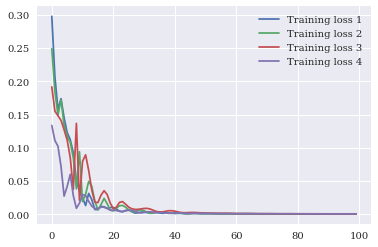

In [357]:
plt.plot(hist, label="Training loss 1")
plt.plot(hist2, label="Training loss 2")
plt.plot(hist3, label="Training loss 3")
plt.plot(hist4, label="Training loss 4")
plt.legend()
plt.show()

In [358]:
np.shape(y_train_pred)

torch.Size([1078, 1])

In [359]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# make predictions
y_test_pred2 = model2(x_test2)

# invert predictions
y_train_pred2 = scaler.inverse_transform(y_train_pred2.detach().numpy())
y_train2 = scaler.inverse_transform(y_train2.detach().numpy())
y_test_pred2 = scaler.inverse_transform(y_test_pred2.detach().numpy())
y_test2 = scaler.inverse_transform(y_test2.detach().numpy())

# make predictions
y_test_pred3 = model3(x_test3)

# invert predictions
y_train_pred3 = scaler.inverse_transform(y_train_pred3.detach().numpy())
y_train3 = scaler.inverse_transform(y_train3.detach().numpy())
y_test_pred3 = scaler.inverse_transform(y_test_pred3.detach().numpy())
y_test3 = scaler.inverse_transform(y_test3.detach().numpy())

# make predictions
y_test_pred4 = model4(x_test4)

# invert predictions
y_train_pred4 = scaler.inverse_transform(y_train_pred4.detach().numpy())
y_train4 = scaler.inverse_transform(y_train4.detach().numpy())
y_test_pred4 = scaler.inverse_transform(y_test_pred4.detach().numpy())
y_test4 = scaler.inverse_transform(y_test4.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score 1: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score 1: %.2f RMSE' % (testScore))

# calculate root mean squared error
trainScore2 = math.sqrt(mean_squared_error(y_train2[:,0], y_train_pred2[:,0]))
print('Train Score 2: %.2f RMSE' % (trainScore2))
testScore2 = math.sqrt(mean_squared_error(y_test2[:,0], y_test_pred2[:,0]))
print('Test Score 2: %.2f RMSE' % (testScore2))

# calculate root mean squared error
trainScore3 = math.sqrt(mean_squared_error(y_train3[:,0], y_train_pred3[:,0]))
print('Train Score 3: %.2f RMSE' % (trainScore3))
testScore3 = math.sqrt(mean_squared_error(y_test3[:,0], y_test_pred3[:,0]))
print('Test Score 3: %.2f RMSE' % (testScore3))

# calculate root mean squared error
trainScore4 = math.sqrt(mean_squared_error(y_train4[:,0], y_train_pred4[:,0]))
print('Train Score 4: %.2f RMSE' % (trainScore4))
testScore4 = math.sqrt(mean_squared_error(y_test4[:,0], y_test_pred4[:,0]))
print('Test Score 4: %.2f RMSE' % (testScore4))

Train Score 1: 2.19 RMSE
Test Score 1: 5.35 RMSE
Train Score 2: 2.22 RMSE
Test Score 2: 6.51 RMSE
Train Score 3: 2.21 RMSE
Test Score 3: 8.67 RMSE
Train Score 4: 2.33 RMSE
Test Score 4: 9.03 RMSE


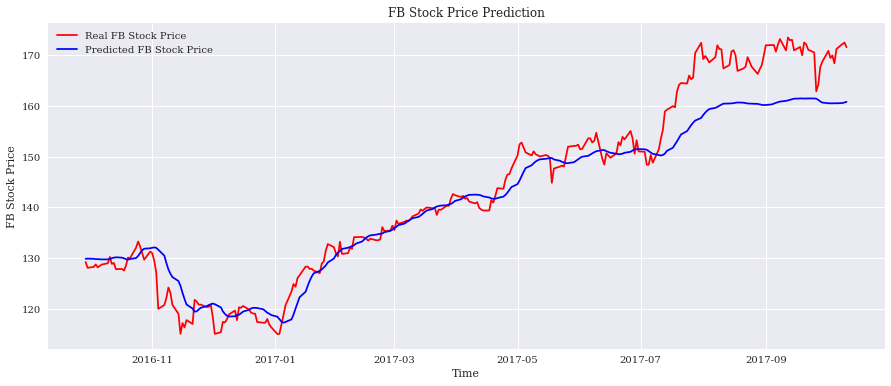

In [360]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test, color = 'red', label = 'Real FB Stock Price')
axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted FB Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('FB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.savefig('fb_pred.png')
plt.show()